In [21]:
!pip install xgboost -q
from xgboost import XGBClassifier

In [22]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

dataset = load_dataset("Asap7772/NYT-Connections-Processed")["train"]
print(f"Dataset veličina: {len(dataset)} zagonetki")

all_embeddings = []
all_labels = []

model = SentenceTransformer('all-mpnet-base-v2')

for i, puzzle in enumerate(dataset):
    words = puzzle["words"]
    true_answers = [group["words"] for group in puzzle["answers"]]

    embeddings = model.encode(words)

    # Labels: svaka riječ dobiva ID svoje grupe (0-3)
    labels = np.zeros(len(words))
    for gid, group in enumerate(true_answers):
        for word in group:
            labels[words.index(word)] = gid

    all_embeddings.append(embeddings)
    all_labels.append(labels)

# 3. Flatten u jedan veliki dataset
X = np.vstack(all_embeddings)
y = np.hstack(all_labels)

print(f"Train dataset: {X.shape[0]} uzoraka, {X.shape[1]} dimenzija")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# RandomForest
#clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=8, random_state=42)
clf.fit(X_train, y_train)

# Evaluacija
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"TEST ACCURACY: {accuracy:.1f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Grupa 0', 'Grupa 1', 'Grupa 2', 'Grupa 3']))

Dataset veličina: 553 zagonetki
Train dataset: 8848 uzoraka, 768 dimenzija
TEST ACCURACY: 27.8%

Classification Report:
              precision    recall  f1-score   support

     Grupa 0       0.30      0.31      0.30       443
     Grupa 1       0.24      0.26      0.25       442
     Grupa 2       0.28      0.28      0.28       443
     Grupa 3       0.30      0.27      0.28       442

    accuracy                           0.28      1770
   macro avg       0.28      0.28      0.28      1770
weighted avg       0.28      0.28      0.28      1770



In [23]:
train_acc = accuracy_score(y_train, clf.predict(X_train)) * 100
test_acc = accuracy_score(y_test, clf.predict(X_test)) * 100
print(f"Train: {train_acc:.1f}% | Test: {test_acc:.1f}%")


Train: 77.6% | Test: 27.8%


In [24]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    max_iter=2000,
    random_state=42,
    multi_class='multinomial',
    solver='lbfgs'
)
clf.fit(X_train, y_train)

train_acc = accuracy_score(y_train, clf.predict(X_train)) * 100
test_acc = accuracy_score(y_test, clf.predict(X_test)) * 100
print(f"LogisticRegression - Train: {train_acc:.1f}% | Test: {test_acc:.1f}%")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression - Train: 42.5% | Test: 33.2%


In [25]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', C=0.5, probability=True, random_state=42)
clf.fit(X_train, y_train)
print("SVM:", accuracy_score(y_test, clf.predict(X_test))*100)

SVM: 32.3728813559322


In [26]:
def evaluate_clustering(predicted_groups, true_answers):
    total_correct = 0
    for pred_group in predicted_groups:
        for true_group in true_answers:
            matches = len(set(pred_group) & set(true_group))
            if matches >= 4:
                total_correct += 4
                break
    return total_correct / 16 * 100, total_correct


In [27]:
#TEST
test_puzzle = dataset[13]
test_words = test_puzzle["words"]
test_embeddings = model.encode(test_words)
group_probs = clf.predict_proba(test_embeddings)  # Shape: (16, 4)

test_predicted_groups = [[] for _ in range(4)]
for gid in range(4):
    group_indices = np.argsort(-group_probs[:, gid])[:4]
    test_predicted_groups[gid] = [test_words[idx] for idx in group_indices]

true_answers = [group["words"] for group in test_puzzle["answers"]]
acc, correct = evaluate_clustering(test_predicted_groups, true_answers)

print("Predviđene grupe:", test_predicted_groups)
print("Točne grupe:", true_answers)
print(f"Accuracy: {acc:.1f}% ({correct}/16)")

Predviđene grupe: [['BURY', 'TRADITIONAL', 'MINCE', 'FLUSH'], ['CHOP', 'PAIR', 'CURRENT', 'MINCE'], ['STRAIGHT', 'DICE', 'RICH', 'SQUARE'], ['CUBE', 'DICE', 'LEACHY', 'LOADED']]
Točne grupe: [['FLUSH', 'LOADED', 'RICH', 'WEALTHY'], ['CHOP', 'CUBE', 'DICE', 'MINCE'], ['SQUARE', 'STRAIGHT', 'STUFFY', 'TRADITIONAL'], ['BURY', 'CURRENT', 'LEACHY', 'PAIR']]
Accuracy: 0.0% (0/16)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


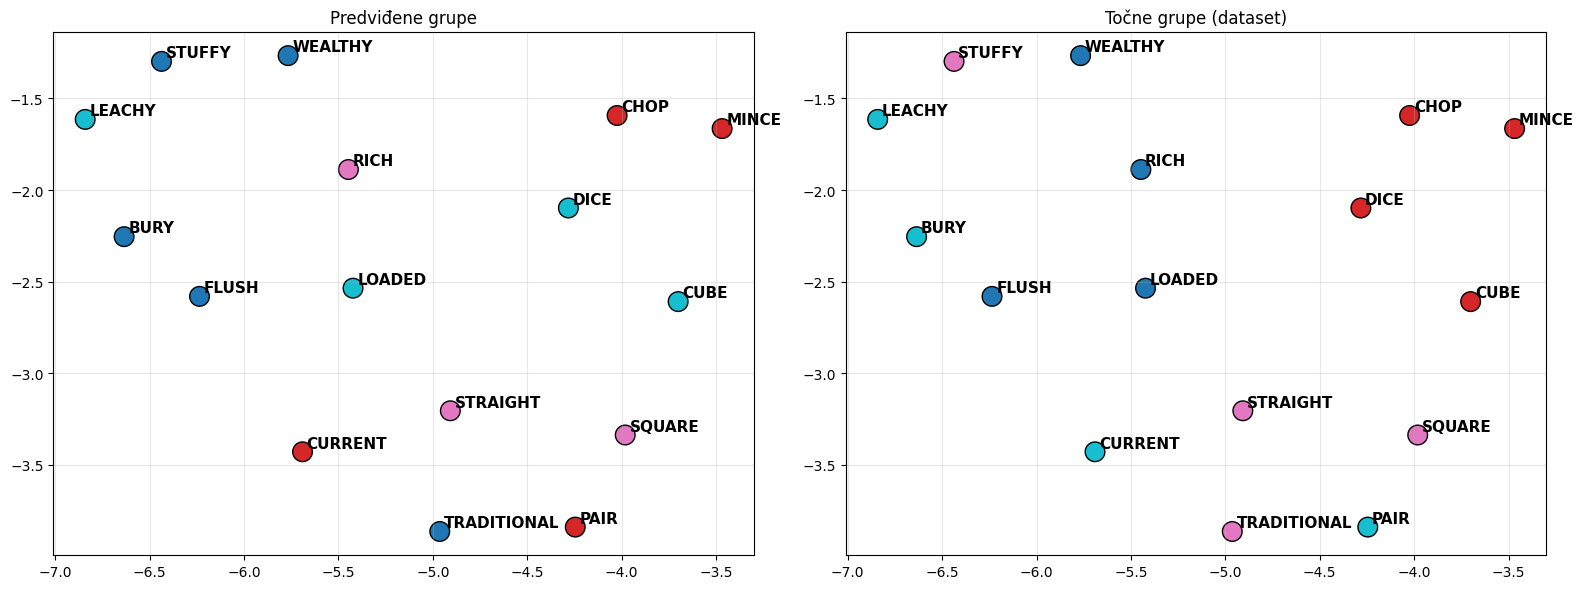

In [28]:
import matplotlib.pyplot as plt
import umap
import numpy as np

true_labels = np.zeros(len(test_words))
for gid, true_group in enumerate(true_answers):
    for word in true_group:
        true_labels[test_words.index(word)] = gid

pred_labels = np.zeros(len(test_words))
for gid, pred_group in enumerate(test_predicted_groups):
    for word in pred_group:
        pred_labels[test_words.index(word)] = gid

reducer = umap.UMAP(random_state=42, n_neighbors=6, min_dist=0.1)
embed_2d = reducer.fit_transform(test_embeddings)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Predikcije
scatter1 = ax1.scatter(embed_2d[:, 0], embed_2d[:, 1],
                      c=pred_labels, cmap='tab10', s=200, edgecolors='black', linewidth=1)
for i, word in enumerate(test_words):
    ax1.annotate(word, (embed_2d[i, 0], embed_2d[i, 1]),
                xytext=(3, 3), textcoords='offset points', fontsize=11, fontweight='bold')
ax1.set_title(f'Predviđene grupe')
ax1.grid(True, alpha=0.3)

# Točne
scatter2 = ax2.scatter(embed_2d[:, 0], embed_2d[:, 1],
                      c=true_labels, cmap='tab10', s=200, edgecolors='black', linewidth=1)
for i, word in enumerate(test_words):
    ax2.annotate(word, (embed_2d[i, 0], embed_2d[i, 1]),
                xytext=(3, 3), textcoords='offset points', fontsize=11, fontweight='bold')
ax2.set_title('Točne grupe (dataset)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
